In [1]:
import sys
import os
from pathlib import Path

sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
import umap
import matplotlib.pyplot as plt


from utils.data import (
    get_fashion_mnist_image_np_arrays,
    get_fashion_mnist_labels_np_arrays,
    UMAPImageDataset,
    ClassificationDataset,
)
from utils.autoencoder import MNISTAutoencoder
from utils.loss import UMAPAutoencoderLoss
from utils.train_functions import (
    train_autoencoder,
    train_autoencoder_with_umap,
    test_autoencoder_reconstruction,
    test_autoencoder_umap_embedding,
)

c:\Users\peper\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Fashion MNIST images

In [2]:
train_images = get_fashion_mnist_image_np_arrays(train=True)
test_images = get_fashion_mnist_image_np_arrays(train=False)

# Labels for visualization purposes
train_labels = get_fashion_mnist_labels_np_arrays(train=True)
test_labels = get_fashion_mnist_labels_np_arrays(train=False)

# UMAP embeddings

## Generate  & save embeddings

In [ ]:
embedding_dim = 2

full_images = np.concatenate([train_images, test_images], axis=0)
flat_full_images = full_images.reshape(full_images.shape[0], -1)
reducer = umap.UMAP(n_components=embedding_dim)
full_embeddings = reducer.fit_transform(flat_full_images)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

# Save full embeddings to a file
project_dir = Path("..").resolve()
embeddings_file = (
    project_dir
    / "data"
    / "fashion_mnist"
    / "umap_embeddings"
    / f"embeddings_d{embedding_dim}.npy"
)
embeddings_file.parent.mkdir(parents=True, exist_ok=True)
np.save(embeddings_file, full_embeddings)

## Load embeddings (if already saved)

In [ ]:
embedding_dim = 2

project_dir = Path("..").resolve()
data_dir = project_dir / "data" / "fashion_mnist" / "umap_embeddings"
embeddings_file = data_dir / f"embeddings_d{embedding_dim}.npy"

# Check if embeddings exist, if not generate them (for first run convenience)
if not embeddings_file.exists():
    print("Embeddings not found, generating...")
    full_images = np.concatenate([train_images, test_images], axis=0)
    flat_full_images = full_images.reshape(full_images.shape[0], -1)
    # Using a small subset for speed if needed, but here we do full
    # For very large datasets, consider parametric UMAP or subsampling
    reducer = umap.UMAP(n_components=embedding_dim)
    full_embeddings = reducer.fit_transform(flat_full_images)
    
    embeddings_file.parent.mkdir(parents=True, exist_ok=True)
    np.save(embeddings_file, full_embeddings)
else:
    full_embeddings = np.load(embeddings_file)

full_images = np.concatenate([train_images, test_images], axis=0)
flat_full_images = full_images.reshape(full_images.shape[0], -1)

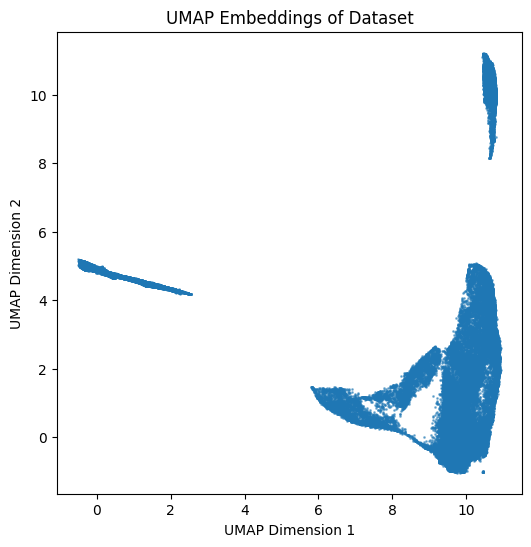

In [5]:
# Plot embeddings
plt.figure(figsize=(6, 6))
plt.scatter(full_embeddings[:, 0], full_embeddings[:, 1], s=1, alpha=0.5)
plt.title("UMAP Embeddings of Dataset")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


# Train Autoencoders

## Train & Test split

In [6]:
# Datasets
# Note: UMAPImageDataset handles the permute internally if needed, 
# but here we are passing flattened images for the simple MLP autoencoder.
# If we switch to CNN autoencoder, we should pass (N, 32, 32, 3) and let dataset handle it.
# The current Autoencoder is MLP, so we flatten.

flat_train_images = train_images.reshape(train_images.shape[0], -1)
flat_test_images = test_images.reshape(test_images.shape[0], -1)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

flat_train_dataset = UMAPImageDataset(
    images=flat_train_images, umap_embeddings=train_embeddings
)
flat_test_dataset = UMAPImageDataset(
    images=flat_test_images, umap_embeddings=test_embeddings
)

flat_train_loader = torch.utils.data.DataLoader(
    flat_train_dataset, batch_size=128, shuffle=True
)
flat_test_loader = torch.utils.data.DataLoader(
    flat_test_dataset, batch_size=128, shuffle=False
)

## Create models

In [7]:
autoencoder_input_dim = flat_full_images.shape[1]
umap_autoencoder = MNISTAutoencoder(
    input_dim=autoencoder_input_dim, embedding_dim=embedding_dim
)
normal_autoencoder = MNISTAutoencoder(
    input_dim=autoencoder_input_dim, embedding_dim=embedding_dim
)
print(umap_autoencoder)

MNISTAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


## Train normal Autoencoder

In [8]:
# Train
normal_criterion = torch.nn.MSELoss()
normal_optimizer = torch.optim.Adam(normal_autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

normal_num_epochs = 5

train_autoencoder(
    model=normal_autoencoder,
    dataloader=flat_train_loader,
    criterion=normal_criterion,
    optimizer=normal_optimizer,
    num_epochs=normal_num_epochs,
    device=device,
)

Epoch [1/5], Loss: 0.0332
Epoch [2/5], Loss: 0.0184
Epoch [3/5], Loss: 0.0155
Epoch [4/5], Loss: 0.0140
Epoch [5/5], Loss: 0.0130
Training complete.


## Train Autoencoder with UMAP as teacher

In [9]:
# Train
umap_criterion = UMAPAutoencoderLoss(reconstruction_weight=0.5, umap_weight=0.5)
umap_optimizer = torch.optim.Adam(umap_autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

umap_num_epochs = 20

train_autoencoder_with_umap(
    model=umap_autoencoder,
    dataloader=flat_train_loader,
    criterion=umap_criterion,
    optimizer=umap_optimizer,
    num_epochs=umap_num_epochs,
    device=device,
)


Epoch [1/20], Loss: 0.7476
Epoch [2/20], Loss: 0.0600
Epoch [3/20], Loss: 0.0413
Epoch [4/20], Loss: 0.0345
Epoch [5/20], Loss: 0.0298
Epoch [6/20], Loss: 0.0290
Epoch [7/20], Loss: 0.0243
Epoch [8/20], Loss: 0.0239
Epoch [9/20], Loss: 0.0223
Epoch [10/20], Loss: 0.0219
Epoch [11/20], Loss: 0.0212
Epoch [12/20], Loss: 0.0197
Epoch [13/20], Loss: 0.0194
Epoch [14/20], Loss: 0.0183
Epoch [15/20], Loss: 0.0181
Epoch [16/20], Loss: 0.0175
Epoch [17/20], Loss: 0.0174
Epoch [18/20], Loss: 0.0162
Epoch [19/20], Loss: 0.0167
Epoch [20/20], Loss: 0.0147
Training complete.


# Compare results

## Compare image results

### Plot normal Autoencoder results

Normal Autoencoder Results


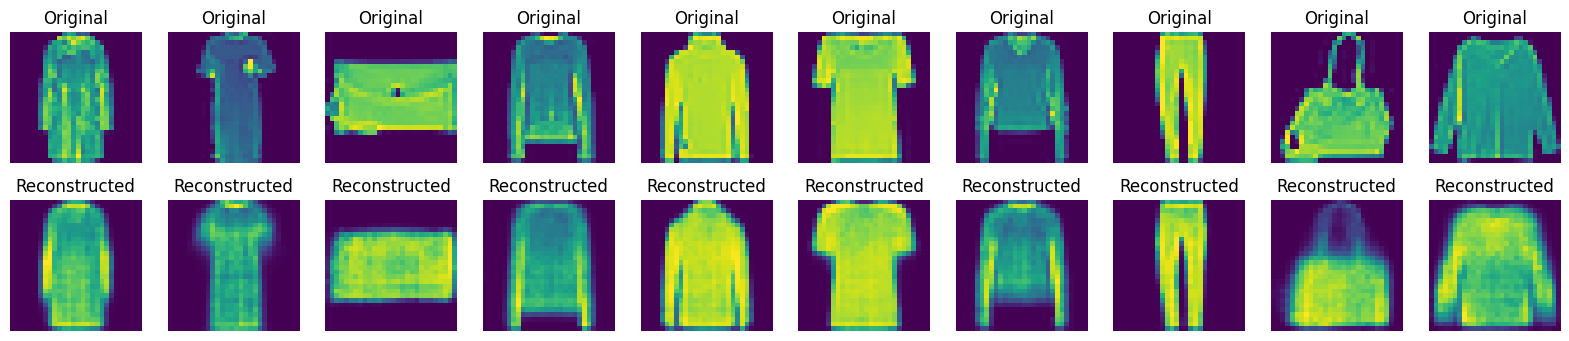

In [10]:
def plot_reconstruction(model, dataset, n=10):
    model.eval()
    indices = np.random.choice(len(dataset), n, replace=False)
    originals = []
    reconstructions = []
    
    with torch.no_grad():
        for idx in indices:
            img, _ = dataset[idx]
            # img is flat tensor
            originals.append(img.numpy().reshape(28, 28))
            
            img_tensor = img.unsqueeze(0).to(device)
            recon = model(img_tensor)
            reconstructions.append(recon.cpu().numpy().reshape(28, 28))
            
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i])
        plt.title("Original")
        plt.axis("off")

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

print("Normal Autoencoder Results")
plot_reconstruction(normal_autoencoder, flat_test_dataset)

### Plot UMAP Autoencoder results

UMAP Autoencoder Results


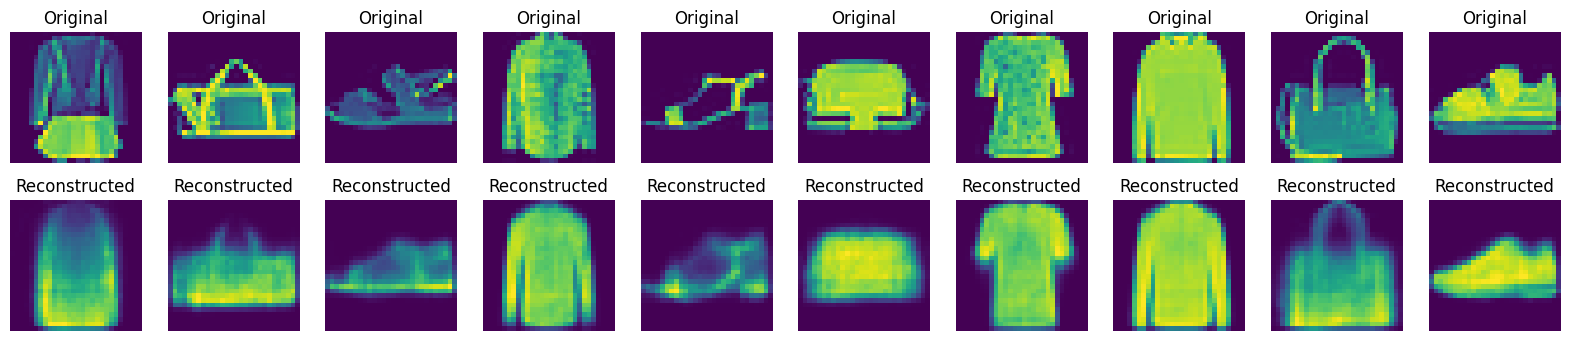

In [11]:
print("UMAP Autoencoder Results")
plot_reconstruction(umap_autoencoder, flat_test_dataset)

## Grid Interpolation with Autoencoder Decoder

We generate a grid of points in the UMAP embedding space and use the trained Autoencoder's decoder to reconstruct images from these points.

In [12]:
from matplotlib.gridspec import GridSpec

# Generate grid points
corners = np.array([
    [12, -5],  # boots?
    [-3, 3],  # bags 
    [13, 4],  # shirts/tops/dresses
    [11, 14],  # pants
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

# Decode points
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

umap_autoencoder.eval()
with torch.no_grad():
    test_pts_torch = torch.from_numpy(test_pts).float().to(device)
    decoded_images = umap_autoencoder.decoder(test_pts_torch)
    decoded_images = decoded_images.view(-1, 28, 28).cpu().numpy()

# Plot
fig = plt.figure(figsize=(12,6))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

# Scatter plot of embeddings (using test_embeddings from earlier)
# We assume test_labels is one-hot encoded based on previous cells
if len(test_labels.shape) > 1 and test_labels.shape[1] > 1:
    test_labels_indices = np.argmax(test_labels, axis=1)
else:
    test_labels_indices = test_labels

scatter_ax.scatter(test_embeddings[:, 0], test_embeddings[:, 1],
                   c=test_labels_indices, cmap='Spectral', s=0.1)
scatter_ax.set(xticks=[], yticks=[])

# Plot test points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=15)

# Plot reconstructed images
for i in range(10):
    for j in range(10):
        digit_axes[i, j].imshow(decoded_images[i*10 + j], cmap='gray')
        digit_axes[i, j].set(xticks=[], yticks=[])

plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x2 and 20x256)